## Intro to Data Science Visualization with datashader
Visualization is one of the key parts in a Data Science project. It allows us to get a global sense of our data and to understand better our results. 
There are many free and non-free tools in the market to make data visualization. One of my favourites is [datashader](https://github.com/bokeh/datashader), an open source python library that allows to visualize big amounts of data with a clean and nice API. 

In [62]:
#Load all libraries
import pandas as pd
import numpy as np
import xarray as xr
import datashader as ds
import datashader.transfer_functions as tf
from datashader import reductions
from bokeh.palettes import Greens3
from datashader.colors import inferno
from datashader.bokeh_ext import InteractiveImage
from bokeh.plotting import figure, output_notebook
from bokeh.tile_providers import WMTSTileSource, STAMEN_TONER, STAMEN_TERRAIN
import os,sys
output_notebook()


Loading BokehJS ...

Let's start with something simple. Let's draw a set of points taken from a gaussian distribution of 2 different categories. Each category will be composed by 100.000 points. The first one has a wide standard deviation, so it will be scattered, and the second one will be more compressed. 

In [2]:
# Dataset generation
np.random.seed(1)
num=100000
dists = {cat: pd.DataFrame(dict(x=np.random.normal(x,std,num),
                                y=np.random.normal(y,std,num),
                                val=val,cat=cat))
         for x,y,std,val,cat in 
         [(3,3,5,10,"d1"), (2,-5,0.2,50,"d2")]}
df = pd.concat(dists,ignore_index=True)
df["cat"]=df["cat"].astype("category")
df.tail()

,cat,val,x,y
199995,d2,50,1.667631,-5.148703
199996,d2,50,1.904505,-5.090921
199997,d2,50,2.051864,-4.807369
199998,d2,50,2.085428,-5.103127
199999,d2,50,2.004584,-4.879147


With datashader we can control the canvas size and how to show the data. In this case we are aggregating data. You can also control the colors and the background. In this case we are going to represent the data like if you were in Matrix.

In [3]:
%%time 
canvas = ds.Canvas(plot_width=400, plot_height=400, x_range=(-10,10), y_range=(-10,10))
agg = canvas.points(df,'x','y',agg=reductions.count())
img = tf.shade(agg, cmap=Greens3, how='eq_hist')
img = tf.set_background(img,"black")

Wall time: 317 ms


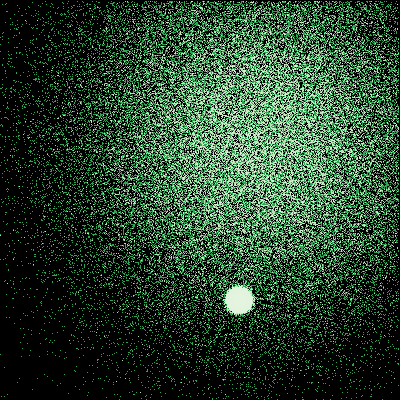

In [4]:
img

### Visualization of Champions League matches
We can easily create a visualization of the Champion League matches from 1955 to 2016 using datashader. For that we need a dataset of the matches, such as [this one](https://github.com/jalapic/engsoccerdata/blob/master/data-raw/champs.csv) and the coordinates of the Stadiums of the teams, that you can find [here](http://opisthokonta.net/?cat=34). 

The first step is to treat the data.

In [48]:
df_match = pd.read_csv("champions.csv")
df_stadium = pd.read_csv("stadiums.csv")
df_match.head()
df_stadium.head()
dd = df_stadium[['Latitude','Longitude']]
dd1 = dd.take([0,99])
dd1

,Latitude,Longitude
0,51.55500,-0.108611
99,40.45306,-3.688350


In [65]:
plot_width  = 850
plot_height = 600
#x_range = (-2.0e6, 2.5e6)
#y_range = (4.1e6, 7.8e6)
x_range = (30,60)
y_range = (-5,5)
def create_image(x_range=x_range, y_range=y_range, w=plot_width, h=plot_height):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.line(dd1, 'Latitude', 'Longitude',  ds.count())
    img = tf.shade(agg)
        
    return img

def base_plot(tools='pan,wheel_zoom,reset',plot_width=plot_width, plot_height=plot_height,**plot_args):
    p = figure(tools=tools, plot_width=plot_width, plot_height=plot_height,
        x_range=x_range, y_range=y_range, outline_line_color=None,
        min_border=0, min_border_left=0, min_border_right=0,
        min_border_top=0, min_border_bottom=0, **plot_args)
    
    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    
    return p

#img = create_image(dd1)
ArcGIS=WMTSTileSource(url='http://server.arcgisonline.com/ArcGIS/rest/services/World_Street_Map/MapServer/tile/{Z}/{Y}/{X}.png')
p = base_plot()
p.add_tile("Eur")
InteractiveImage(p, create_image)



ValueError: expected an instance of type TileSource, got Europe.png of type str

Some of the code in this notebook has been taken from the example folder of [datashader](https://github.com/bokeh/datashader/tree/master/examples).